In [16]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
#import xesmf as xe
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import gridspec
import cartopy.mpl.ticker as cticker
import scipy
import scipy.stats
import csv 
from defs import mmm, lon180

In [17]:
folder = 'Data_processed/'
modellist =  ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

In [18]:
dsgrid = xr.open_dataset(folder+'1x1grid.nc')
area = dsgrid.area

#Open and calculate MMM SST
dsE280t = xr.open_dataset(folder+'MMM_ensemble/E280/thetao_1x1_100yr.nc')
dsEoi400t = xr.open_dataset(folder+'MMM_ensemble/Eoi400/thetao_1x1_100yr.nc')

sstE280 = lon180(mmm(dsE280t.thetao[:,0]))
sstEoi400 = lon180(mmm(dsEoi400t.thetao[:,0]))

#Open and calculate MMM sea-ice cover
dsE280 = xr.open_dataset(folder+'MMM_ensemble/E280/SI_100yr.nc')
dsEoi400 = xr.open_dataset(folder+'MMM_ensemble/Eoi400/SI_100yr.nc')

siE280 = lon180(mmm(dsE280.si_mean))
siEoi400 = lon180(mmm(dsEoi400.si_mean))

In [19]:
#Code for extracting proxy and pre-industrial data adapted from Oldeman et al. (2021), https://doi.org/10.5281/zenodo.5718483, 2021
#Last access: 24-01-2022

In [20]:
## ERSSTv5 data, 2x2 degree
## Huang et al., 2017, 1870-1899 SST data (pre-processed into one dataset, each year is downloaded separately)
## Downloaded 1870-1899 files compressed into one: see Processing/pre-processing/ERSSTv5.ipynb
## https://www.ncei.noaa.gov/products/extended-reconstructed-sst
file = folder+'Observations/ERSSTv5.nc'
ds   = xr.open_dataset(file)
ds = lon180(ds) #Convert longitude to [-180,180]
ersst = ds.sst[:,0].mean(dim='time')

In [21]:
# 'MC' proxy reconstructions
# McClymont et al 2020 dataset, PlioVAR, both UK37 with BAYSLINE calib, and Mg/Ca reconstr
# https://doi.pangaea.de/10.1594/PANGAEA.911847
# last access 24-01-2022

file = folder + 'Observations/PlioVAR-KM5c_T.tab'

with open(file, encoding='windows-1252') as f:
    ds = [column for column in csv.reader(f,delimiter='\t')]

Nstart = 99; Nend   = len(ds);
iLat   = 2; iLon   = 3; iUk    = 6; iMg    = 7;

MC_lat = np.zeros(Nend-Nstart)
MC_lon = np.zeros(Nend-Nstart)
MC_Uk  = np.zeros(Nend-Nstart)
MC_Mg  = np.zeros(Nend-Nstart)

for i in range(Nstart, Nend):
    MC_lat[i-Nstart] = ds[i][iLat]
    MC_lon[i-Nstart] = ds[i][iLon]
    if ds[i][iUk]=='': MC_Uk[i-Nstart] = np.nan;
    else: MC_Uk[i-Nstart] = ds[i][iUk]
    if ds[i][iMg]=='': MC_Mg[i-Nstart] = np.nan
    else: MC_Mg[i-Nstart] = ds[i][iMg]

# select only North Atlantic data
a = np.array([MC_lat, MC_lon, MC_Uk, MC_Mg])
MC_S = a[:,a[0,:]<-30]

#PI SST values at NA locations
ersst_MC = np.zeros(MC_S.shape[1]);
deg = 1

for i in range(MC_S.shape[1]):
    ersst_MC[i] = ersst.sel(lon = MC_S[1,i], method='nearest').sel(lat = MC_S[0,i], method='nearest')

In [22]:
sstE280all = dsE280t.thetao[:,0]
sstEoi400all = dsEoi400t.thetao[:,0]

In [23]:
#Compute SSTs at proxy locations for all models invididually
modelsE280_MC = np.zeros([len(modellist),MC_S.shape[1]]);
modelsEoi400_MC = np.zeros([len(modellist),MC_S.shape[1]]);

deg = 1

for i in range(len(modellist)):
    for j in range(MC_S.shape[1]):
        modelsE280_MC[i,j] = sstE280all[i].sel(lon = MC_S[1,j], method='nearest').sel(lat = MC_S[0,j], method='nearest')
        modelsEoi400_MC[i,j] = sstEoi400all[i].sel(lon = MC_S[1,j], method='nearest').sel(lat = MC_S[0,j], method='nearest')

/var/folders/f4/c_hqzq2n50q925l69wbn3_dw0000gn/T/ipykernel_62545/1277666345.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap0 = plt.cm.get_cmap("cmo.thermal",6).copy()
/var/folders/f4/c_hqzq2n50q925l69wbn3_dw0000gn/T/ipykernel_62545/1277666345.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = plt.cm.get_cmap("cmo.ice").copy()
/var/folders/f4/c_hqzq2n50q925l69wbn3_dw0000gn/T/ipykernel_62545/1277666345.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap

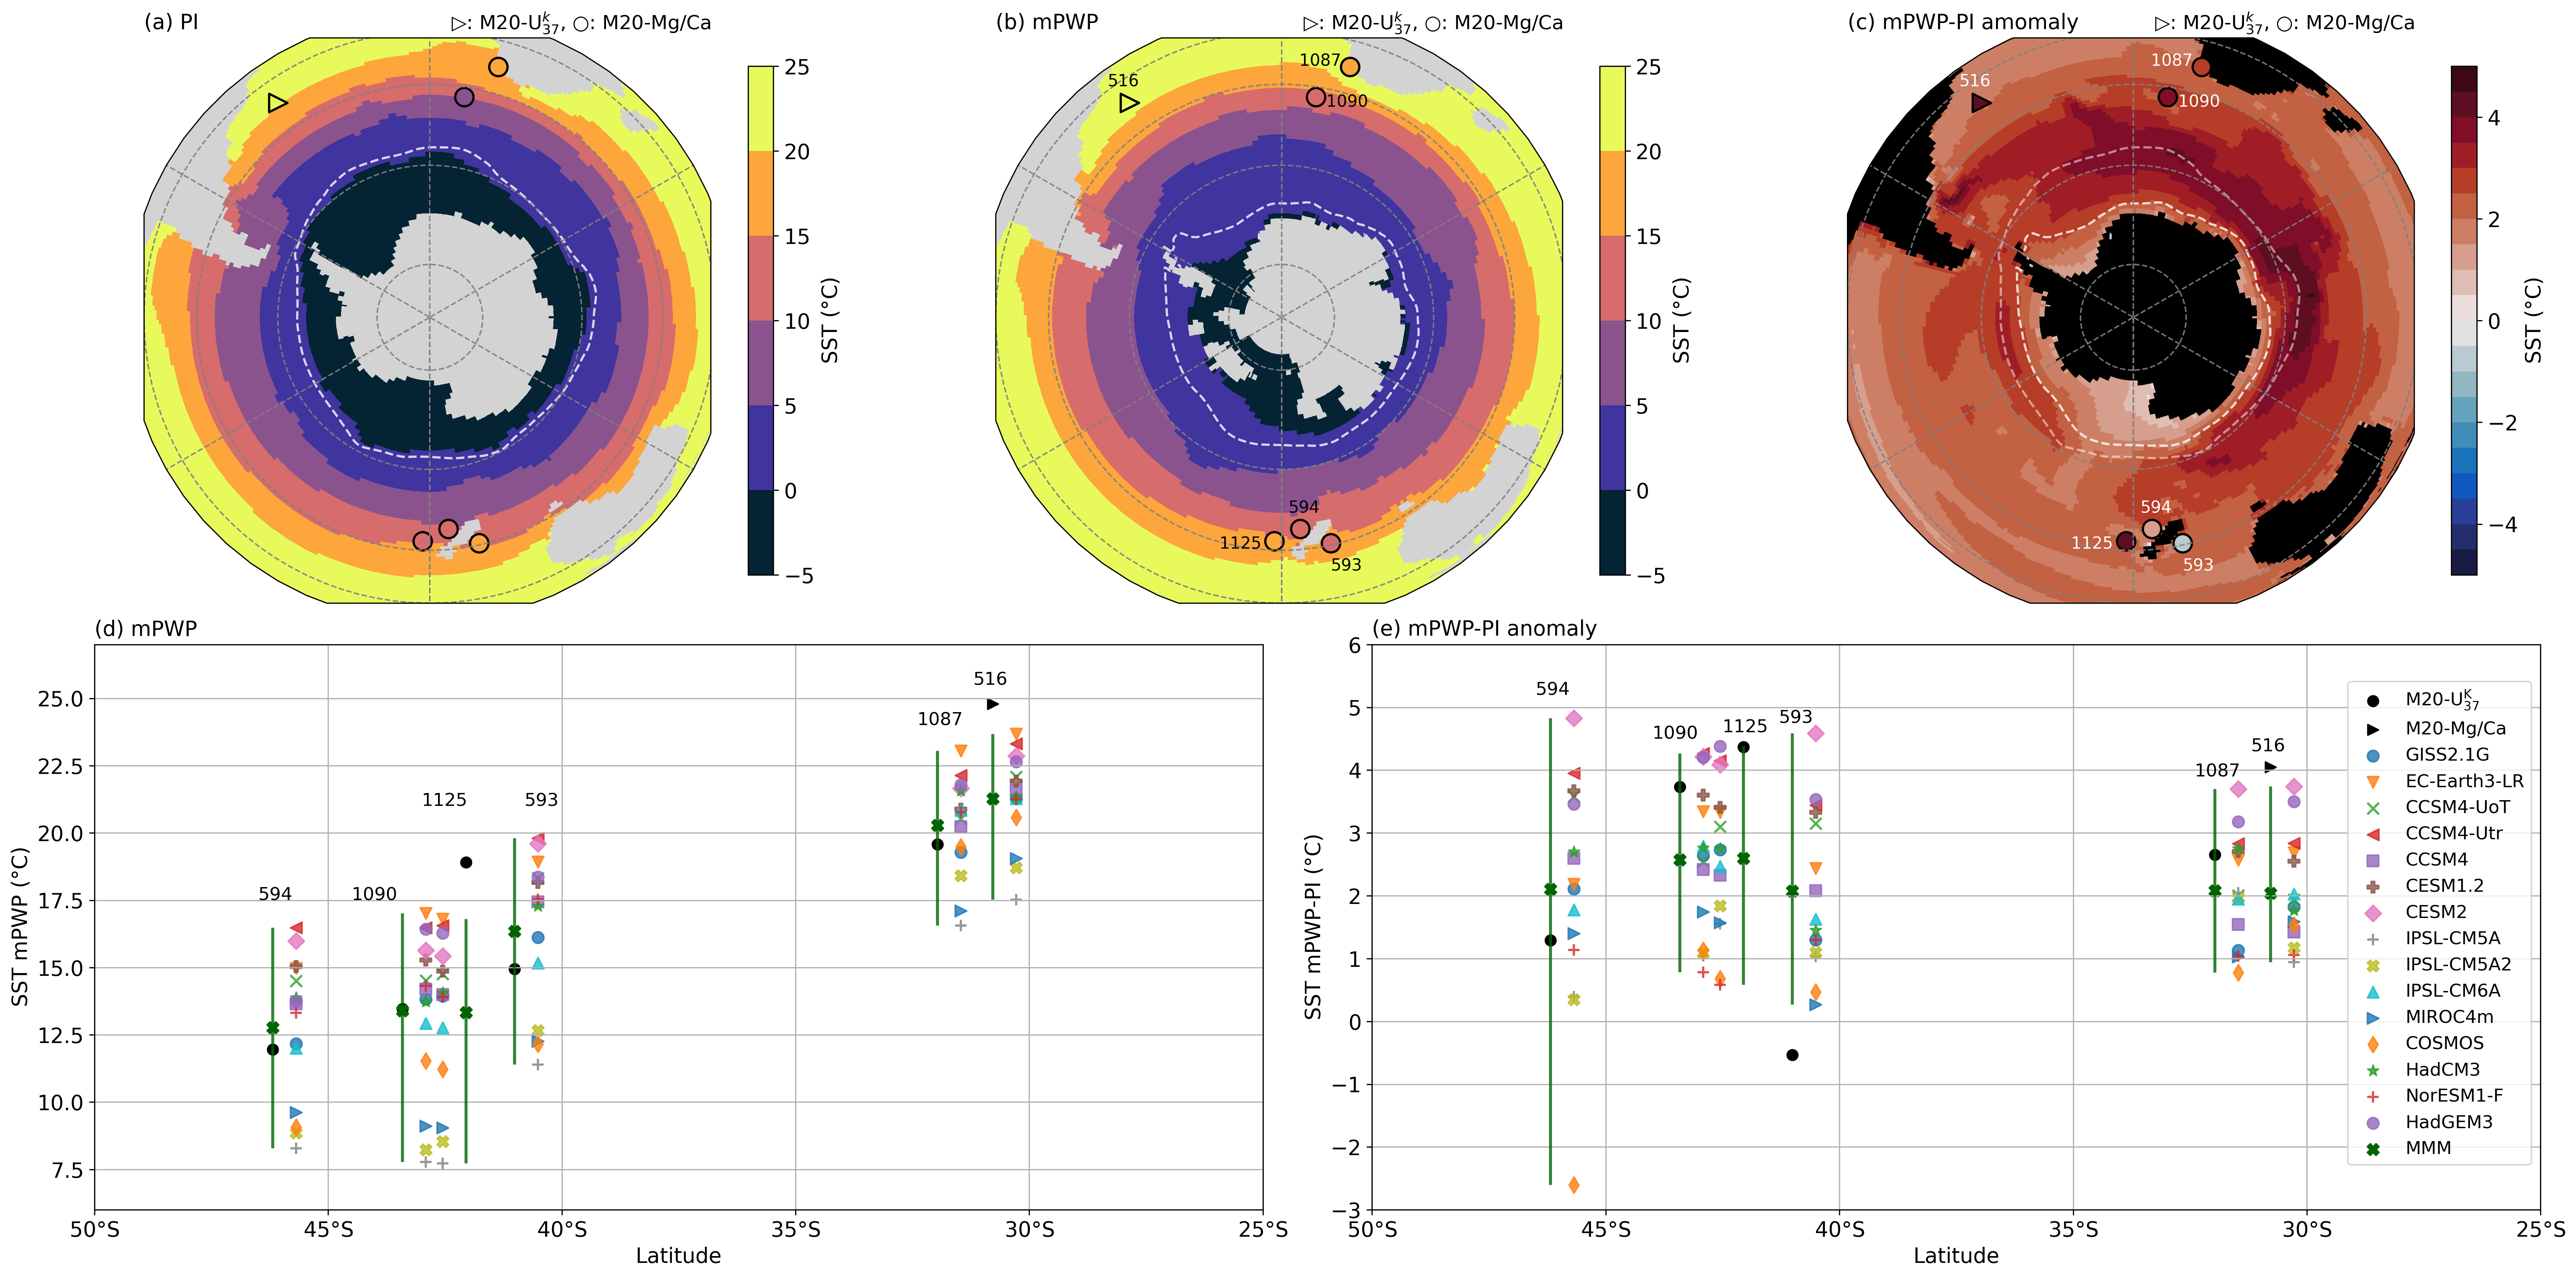

In [24]:
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.rcParams['axes.labelsize'] = 14

## creeer je figuur:
fig = plt.figure(figsize=(24,12), dpi=300)
## creeer je assen. Ik voeg hier de projectie 'plate carree' toe, Cartopy heeft verschillende, bijv EqualEarth
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
spec = fig.add_gridspec(2, 12)

cmap0 = plt.cm.get_cmap("cmo.thermal",6).copy()
cmap0.set_under('lightgrey')

cmap1 = plt.cm.get_cmap("cmo.ice").copy()
cmap1.set_under('lightgrey')

cmap2 = plt.cm.get_cmap("cmo.balance",20).copy()
cmap2.set_under('black')

iceline = 15

ax = fig.add_subplot(spec[0, 0:4], projection=proj)
im=ax.pcolormesh(sstE280.lon,sstE280.lat,sstE280.fillna(-100), transform=ccrs.PlateCarree(), cmap=cmap0, vmin = -5, vmax = 25)
ax.contour(siE280.lon,siE280.lat,siE280, colors=['w','w'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=0.8, zorder=1,transform=ccrs.PlateCarree())
ax.scatter(MC_S[1,1:], MC_S[0,1:], transform = ccrs.PlateCarree(), marker='o', s=150, edgecolors='k', linewidth=1.5,
           c=(ersst_MC[1:]), cmap=cmap0, vmin = -5, vmax = 25) 
ax.scatter(MC_S[1,0], MC_S[0,0], transform = ccrs.PlateCarree(), marker='>', s=150, edgecolors='k', linewidth=1.5,
           c=(ersst_MC[0]), cmap=cmap0, vmin = -5, vmax = 25) 
ax.set_extent([-180, 180, -90,-20], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'SST ($\degree$C)', fontsize=14)
lat_lines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.9, linestyle='--')
ax.set_title('(a) PI', fontsize=14, loc='left')
ax.set_title(r'$\triangleright$: M20-U$^{k}_{37}$, $\bigcirc$: M20-Mg/Ca', fontsize=13,loc='right')

ax = fig.add_subplot(spec[0, 4:8], projection=proj)
im=ax.pcolormesh(sstE280.lon,sstE280.lat,sstEoi400.fillna(-100), transform=ccrs.PlateCarree(), cmap=cmap0, vmin = -5, vmax = 25)
ax.scatter(MC_S[1,1:], MC_S[0,1:], transform = ccrs.PlateCarree(), marker='o', s=150, edgecolors='k', linewidth=1.5,
           c=(MC_S[2,1:]), cmap=cmap0, vmin = -5, vmax = 25) 
ax.scatter(MC_S[1,0], MC_S[0,0], transform = ccrs.PlateCarree(), marker='>', s=150, edgecolors='k', linewidth=1.5,
           c=(MC_S[3,0]), cmap=cmap0, vmin = -5, vmax = 25) 
ax.contour(siE280.lon,siE280.lat,siEoi400, colors=['w','w'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=0.8, zorder=1,transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90,-20], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'SST ($\degree$C)', fontsize=14)
lat_lines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.9, linestyle='--')
ax.set_title('(b) mPWP', fontsize=14, loc='left')
ax.set_title(r'$\triangleright$: M20-U$^{k}_{37}$, $\bigcirc$: M20-Mg/Ca', fontsize=13,loc='right')
ax.text(169,-32,'593', fontsize=11, transform=ccrs.PlateCarree(), color='k')
ax.text(178,-50,'594', fontsize=11, transform=ccrs.PlateCarree(), color='k')
ax.text(12,-45,'1090', fontsize=11, transform=ccrs.PlateCarree(), color='k')
ax.text(-165,-38,'1125', fontsize=11, transform=ccrs.PlateCarree(), color='k')
ax.text(4,-34,'1087', fontsize=11, transform=ccrs.PlateCarree(), color='k')
ax.text(-37,-18,'516', fontsize=11, transform=ccrs.PlateCarree(), color='k')

ax = fig.add_subplot(spec[0, 8:], projection=proj)
im=ax.pcolormesh(sstE280.lon,sstE280.lat,(sstEoi400-sstE280).fillna(-200), transform=ccrs.PlateCarree(), cmap=cmap2, vmin = -5, vmax = 5)
ax.contour(siE280.lon,siE280.lat,siEoi400, colors=['w','w'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=0.8, zorder=1,transform=ccrs.PlateCarree())
ax.contour(siE280.lon,siE280.lat,siE280, colors=['w','w'], linestyles = ['dashed'], levels=[-1000,iceline], alpha=0.5, zorder=1,transform=ccrs.PlateCarree())
ax.scatter(MC_S[1,1:], MC_S[0,1:], transform = ccrs.PlateCarree(), marker='o', s=150, edgecolors='k', linewidth=1.5,
           c=(MC_S[2,1:]-ersst_MC[1:]), cmap=cmap2, vmin = -5, vmax = 5) 
ax.scatter(MC_S[1,0], MC_S[0,0], transform = ccrs.PlateCarree(), marker='>', s=150, edgecolors='k', linewidth=1.5,
           c=(MC_S[3,0]-ersst_MC[0]), cmap=cmap2, vmin = -5, vmax = 5) 
ax.set_extent([-180, 180, -90,-20], crs=ccrs.PlateCarree())
cb = fig.colorbar(im, ax = ax, orientation='vertical', fraction = 0.12, shrink = 0.9)
cb.set_label(label = 'SST ($\degree$C)', fontsize=14)
ax.set_title('(c) mPWP-PI amomaly', fontsize=14, loc='left')
ax.set_title(r'$\triangleright$: M20-U$^{k}_{37}$, $\bigcirc$: M20-Mg/Ca', fontsize=13,loc='right')
lat_lines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.9, linestyle='--')
ax.text(169,-32,'593', fontsize=11, transform=ccrs.PlateCarree(), color='white')
ax.text(178,-50,'594', fontsize=11, transform=ccrs.PlateCarree(), color='white')
ax.text(12,-45,'1090', fontsize=11, transform=ccrs.PlateCarree(), color='white')
ax.text(-165,-38,'1125', fontsize=11, transform=ccrs.PlateCarree(), color='white')
ax.text(4,-34,'1087', fontsize=11, transform=ccrs.PlateCarree(), color='white')
ax.text(-37,-18,'516', fontsize=11, transform=ccrs.PlateCarree(), color='white')


ax3 = fig.add_subplot(spec[1, 0:6])
x_pos = np.array([-50, -45, -40, -35, -30, -25]) 
xtext = ('50$\degree$S', '45$\degree$S', '40$\degree$S', '35$\degree$S', '30$\degree$S', '25$\degree$S')
markers = ["o","v","x","<","s","P","D","+","X","^",">","d","*","+","o"]
   
for j in np.array([0,1,2,4,5]):
    ax3.vlines(MC_S[0,j]-0.5, np.nanmin(modelsEoi400_MC[:,j]), np.nanmax(modelsEoi400_MC[:,j]), color='darkgreen',zorder=2, alpha=0.8, linewidth=2)
for j in np.array([3]):
    ax3.vlines(MC_S[0,j]+0.5, np.nanmin(modelsEoi400_MC[:,j]), np.nanmax(modelsEoi400_MC[:,j]), color='darkgreen',zorder=2, alpha=0.8, linewidth=2)

for j in np.array([0,1,2,4,5]):
    ax3.scatter(MC_S[0,j]-0.5, MC_S[2,j], color='k',marker = 'o', s=50)
for j in np.array([3]):
    ax3.scatter(MC_S[0,j]+0.5, MC_S[2,j], color='k',marker = 'o', s=50, label='M20-U$\mathregular{^{K}_{37}}$')
    
#ax3.scatter(MC_S[0,3]+0.5, MC_S[2,3]-ersst_MC[3], color='k',marker = '>', s=50)
ax3.scatter(MC_S[0]-0.5, MC_S[3], color='k',marker = '>', s=50, label='M20-Mg/Ca')

for i in range(15):
    ax3.scatter(MC_S[0], modelsEoi400_MC[i], s=60, marker = markers[i], label=modellist[i], alpha=0.8)

for j in np.array([0,1,2,4,5]):
    ax3.scatter(MC_S[0,j]-0.5, np.nanmean(modelsEoi400_MC[:,j], axis=0), s=60, color='darkgreen', marker='X')
for j in np.array([3]):
    ax3.scatter(MC_S[0,j]+0.5, np.nanmean(modelsEoi400_MC[:,j], axis=0), s=60, color='darkgreen', marker='X', label='MMM')

    
#ax.legend(loc='upper left', fontsize=8)
ax3.set_xlim([-50, -25])
ax3.set_xticks(x_pos)
ax3.set_xticklabels(xtext)
ax3.set_xlabel('Latitude')
    
ax3.set_ylabel('SST mPWP ($\degree$C)', fontsize=14)
ax3.grid()
ax3.set_ylim([6, 27])

ax3.text(-46.5, 17.5, '594', fontsize=12)
ax3.text(-44.5, 17.5, '1090', fontsize=12)
ax3.text(-43, 21, '1125', fontsize=12)
ax3.text(-40.8, 21, '593', fontsize=12)
ax3.text(-32.4, 24, '1087', fontsize=12)
ax3.text(-31.2, 25.5, '516', fontsize=12)


ax3.set_title('(d) mPWP', fontsize=14, loc='left')


ax3 = fig.add_subplot(spec[1, 6:])
x_pos = np.array([-50, -45, -40, -35, -30, -25]) 
xtext = ('50$\degree$S', '45$\degree$S', '40$\degree$S', '35$\degree$S', '30$\degree$S', '25$\degree$S')
markers = ["o","v","x","<","s","P","D","+","X","^",">","d","*","+","o"]
   
for j in np.array([0,1,2,4,5]):
    ax3.vlines(MC_S[0,j]-0.5, np.nanmin(modelsEoi400_MC[:,j]-modelsE280_MC[:,j]), np.nanmax(modelsEoi400_MC[:,j]-modelsE280_MC[:,j]), color='darkgreen',zorder=2, alpha=0.8, linewidth=2)
for j in np.array([3]):
    ax3.vlines(MC_S[0,j]+0.5, np.nanmin(modelsEoi400_MC[:,j]-modelsE280_MC[:,j]), np.nanmax(modelsEoi400_MC[:,j]-modelsE280_MC[:,j]), color='darkgreen',zorder=2, alpha=0.8, linewidth=2)

for j in np.array([0,1,2,4,5]):
    ax3.scatter(MC_S[0,j]-0.5, MC_S[2,j]-ersst_MC[j], color='k',marker = 'o', s=50)
for j in np.array([3]):
    ax3.scatter(MC_S[0,j]+0.5, MC_S[2,j]-ersst_MC[j], color='k',marker = 'o', s=50, label='M20-U$\mathregular{^{K}_{37}}$')
    
#ax3.scatter(MC_S[0,3]+0.5, MC_S[2,3]-ersst_MC[3], color='k',marker = '>', s=50)
ax3.scatter(MC_S[0]-0.5, MC_S[3]-ersst_MC, color='k',marker = '>', s=50, label='M20-Mg/Ca')

for i in range(15):
    ax3.scatter(MC_S[0], modelsEoi400_MC[i]-modelsE280_MC[i], s=60, marker = markers[i], label=modellist[i], alpha=0.8)

for j in np.array([0,1,2,4,5]):
    ax3.scatter(MC_S[0,j]-0.5, np.nanmean(modelsEoi400_MC[:,j], axis=0)-np.nanmean(modelsE280_MC[:,j], axis=0), s=60, color='darkgreen', marker='X')
for j in np.array([3]):
    ax3.scatter(MC_S[0,j]+0.5, np.nanmean(modelsEoi400_MC[:,j], axis=0)-np.nanmean(modelsE280_MC[:,j], axis=0), s=60, color='darkgreen', marker='X', label='MMM')

    
#ax.legend(loc='upper left', fontsize=8)
ax3.set_xlim([-50, -25])
ax3.set_xticks(x_pos)
ax3.set_xticklabels(xtext)
ax3.set_xlabel('Latitude')
    
ax3.set_ylabel('SST mPWP-PI ($\degree$C)', fontsize=14)
ax3.legend(bbox_to_anchor=(1., 0.95), fontsize=12.)
ax3.grid()
ax3.set_ylim([-3, 6])

ax3.text(-46.5, 5.2, '594', fontsize=12)
ax3.text(-44, 4.5, '1090', fontsize=12)
ax3.text(-42.5, 4.6, '1125', fontsize=12)
ax3.text(-41.3, 4.75, '593', fontsize=12)
ax3.text(-32.4, 3.9, '1087', fontsize=12)
ax3.text(-31.2, 4.3, '516', fontsize=12)


ax3.set_title('(e) mPWP-PI anomaly', fontsize=14, loc='left')

fig.tight_layout()
#plt.savefig('SFig10.png', bbox_inches='tight')


plt.show()

In [25]:
print('The mean model spread in Eoi400 temperatures is %.1f degC' %np.mean(np.nanmax(modelsEoi400_MC[:,:], axis=0)-np.nanmin(modelsEoi400_MC[:,:], axis=0)))
print('The mean model spread in Eoi400-E280 temperatures is %.1f degC' %np.mean(np.nanmax(modelsEoi400_MC[:,:]-modelsE280_MC[:,:], axis=0)-np.nanmin(modelsEoi400_MC[:,:]-modelsE280_MC[:,:], axis=0)))

The mean model spread in Eoi400 temperatures is 7.9 degC
The mean model spread in Eoi400-E280 temperatures is 4.1 degC
